In [1]:
# Define a class including all functions used

import geopandas
from rasterio import features
from affine import Affine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import netCDF4
import xarray 
import matplotlib.patches as mpatches
import xesmf as xe
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math
from mpl_toolkits.basemap import Basemap
import warnings
import os
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import scipy
from matplotlib.lines import Line2D
from climate_indices import compute, indices, utils
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.stats import t
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns
import json
import pickle
warnings.filterwarnings("ignore")
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder    
 

class evaluation():

    #define functions
    %matplotlib inline
    
    # init 
    def __init__(self):
        print('This is a package to evaluate precipitation simulation performance based on test and observe dataset!\n')
    
    #functions used in interpolation
    def transform_from_latlon(self,lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale    
    
    def rasterize(self,shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
        transform = self.transform_from_latlon(coords[latitude], coords[longitude])
        out_shape = (len(coords[latitude]), len(coords[longitude]))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
        return xarray.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))
    
    #calculate functions
    def rmse(self,predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

    def scored(self,x):
        return np.exp(-x)

    def crmse(self,predictions,predictions_mean, targets,targets_mean):
        return np.sqrt(((predictions - predictions_mean - targets + targets_mean) ** 2).mean())   
    
    def z_test(self,data1,data2,variable1,variable2):
        mu_test = np.mean(data1[variable1])
        mu_ob = np.mean(data2[variable2])
        std_test = np.std(data1[variable1])
        std_ob = np.std(data2[variable2])
        len_test = len(data1)
        len_ob = len(data2)
        z = abs((mu_test-mu_ob)/math.sqrt(pow(std_test,2)/len_test + pow(std_ob,2)/len_ob))
        return z


    
    #evaluate functions
    def read_test_data(self,test_path,test_pr_name):
        self.test = xarray.open_dataset(test_path)
        self.test['pr'] = self.test[test_pr_name]

        if self.test.lon.units == 'degrees_east':
            self.test = self.test.assign_coords({"lon": (((self.test.lon + 180) % 360) - 180)})
            print('Transfer longitude units of test data from degrees_east to degrees_west! \n')
        else:
            print('Longitude units of test data is already degrees_west. \n')

        if self.test.pr.units == 'kg m-2 s-1':
            self.test['pr'] = self.test['pr']* 86400
            print('Transfer precipitation units of test data from kg m-2 s-1 to mm/day! \n')
        else:
            print("Precipitation units of test data is already mm/day. \n")
        
        self.test = self.test.sortby(['lat','lon'])        
        #assign model name, change if other attribute indicates data's model name
        self.model_name = self.test.source_id+' '+ self.test.variant_label
        
        #if test.model indicates model name
        #self.model_name = self.test.model

    
    
    def read_observe_data(self,observe_path,observe_pr_name):
        self.observe = xarray.open_dataset(observe_path)
        self.observe['pr'] = self.observe[observe_pr_name]
        # transfer lon from 0to360 into -180to180
        if self.observe.lon.units == 'degrees_east':
            self.observe = self.observe.assign_coords({"lon": (((self.observe.lon + 180) % 360) - 180)})
            print('Transfer longitude units of observe data from degrees_east to degrees_west! \n')
        else:
            print('Longitude units of observe data is already degrees_west. \n')

        # transfer pr units to mm/day
        if self.observe.pr.units == 'kg m-2 s-1':
            self.observe['pr'] = self.observe['pr']* 86400
            print('Transfer precipitation units of observe data from kg m-2 s-1 to mm/day! \n')
        else:
            print("Precipitation units of test observe is already mm/day. \n")            
        self.observe = self.observe.sortby(['lat','lon'])

        
    def read_weightfile(self,weightfile_path,interpolation = False):
        ##read weightfile data (the destination file used in interpolation)
        # if data are already interpolated, set the interpolation = False to skip the interpolation
        if interpolation == True:
            self.weightfile = xarray.open_dataset(weightfile_path)
            # transfer lon from 0to360 into -180to180
            if self.weightfile.lon.units == 'degrees_east':
                self.weightfile = self.weightfile.assign_coords({"lon": (((self.weightfile.lon + 180) % 360) - 180)})
                print('Transfer longitude units of weightfile from degrees_east to degrees_west! \n')
            else:
                print('Longitude units of weightfile is already degrees_west. \n')

            self.weightfile = self.weightfile.sortby(['lat','lon'])
            
        else:
            self.weightfile = np.nan


        


    def interpolate(self,test,observe,weightfile,interpolation = False,interpolate_type = 'conservative'):
        #or use bilinear by setting interpolate_type = 'bilinear'
        if interpolation == True:
            # set lat_b and lon_b
            a = test.lat + (test.lat[1]-test.lat[2])/2
            b = test.lat[-1] -(test.lat[1]-test.lat[2])/2
            c = test.lon + (test.lon[1]-test.lon[2])/2
            d = test.lon[-1] -(test.lon[1]-test.lon[2])/2
            lat_b = np.append(a, b)
            test = test.assign_coords(lat_b=lat_b)
            lon_b = np.append(c,d)
            test = test.assign_coords(lon_b=lon_b)
            
            #calclute lat_boundary and lon_boundary needed
            a = observe.lat + (observe.lat[1]-observe.lat[2])/2
            b = observe.lat[-1] -(observe.lat[1]-observe.lat[2])/2
            c = observe.lon + (observe.lon[1]-observe.lon[2])/2
            d = observe.lon[-1] -(observe.lon[1]-observe.lon[2])/2
            lat_b = np.append(a, b)
            lon_b = np.append(c,d)
            observe = observe.assign_coords(lat_b=lat_b)
            observe = observe.assign_coords(lon_b=lon_b)
            
            #calclute lat_boundary and lon_boundary needed            
            a = weightfile.lat + (weightfile.lat[1]-weightfile.lat[2])/2
            b = weightfile.lat[-1] -(weightfile.lat[1]-weightfile.lat[2])/2
            c = weightfile.lon + (weightfile.lon[1]-weightfile.lon[2])/2
            d = weightfile.lon[-1] -(weightfile.lon[1]-weightfile.lon[2])/2
            lat_b = np.append(a, b)
            lon_b = np.append(c,d)
            weightfile = weightfile.assign_coords(lat_b=lat_b)
            weightfile = weightfile.assign_coords(lon_b=lon_b)

            print("Interpolate model and observed data into weight file \n")
            regridder = xe.Regridder(test, weightfile, interpolate_type)
            regridder = add_matrix_NaNs(regridder)
            data_input = test['pr']
            self.test_interpolated = regridder(data_input)

            regridder = xe.Regridder(observe, weightfile, interpolate_type)
            regridder = add_matrix_NaNs(regridder)
            data_input = observe['pr']
            self.observe_interpolated = regridder(data_input)
        
        else:
            self.observe_interpolated = self.observe['pr']
            self.test_interpolated = self.test['pr']


    
    def read_shp(self,shp_path):
        states = geopandas.read_file(shp_path)
        shapes = zip(states.geometry, range(len(states)))
        state_ids = {k: i for i, k in enumerate(states.Name)}
        print("In the shp file, there are following regions:\n")
        print(state_ids)
        print('')
    
    def mask_observe(self,shp_path,observe_interpolated,hu_name):
        states = geopandas.read_file(shp_path)
        shapes = zip(states.geometry, range(len(states)))
        state_ids = {k: i for i, k in enumerate(states.Name)}
        observe_interpolated['states'] = self.rasterize(shapes, observe_interpolated.coords, longitude='lon', latitude='lat')
        self.observe_roi = observe_interpolated.where(observe_interpolated.states == state_ids[hu_name])
        #unuse the mask
        #self.observe_roi = observe_interpolated
        self.hu_name = hu_name

 
    def mask_test(self,shp_path,test_interpolated,hu_name):
        states = geopandas.read_file(shp_path)
        shapes = zip(states.geometry, range(len(states)))
        state_ids = {k: i for i, k in enumerate(states.Name)}
        test_interpolated['states'] = self.rasterize(shapes, test_interpolated.coords, longitude='lon', latitude='lat')
        self.test_roi = test_interpolated.where(test_interpolated.states == state_ids[hu_name])
        #unuse the mask
        #self.test_roi = test_interpolated
        self.hu_name = hu_name
           
    # get the time range of two data's overlap range
    def data_time_range(self,test_roi,observe_roi):
        #find the overlap time of test and observe data
        test_time_min = min(test_roi['time.year'])
        test_time_max = max(test_roi['time.year'])

        observe_time_min = min(observe_roi['time.year'])
        observe_time_max = max(observe_roi['time.year'])

        self.data_time_min = test_time_min
        if observe_time_min > self.data_time_min:
            self.data_time_min = observe_time_min

        self.data_time_max = test_time_max
        if observe_time_max < self.data_time_max:
            self.data_time_max = observe_time_max
        print('The time range of test and observe data is from '+str(self.data_time_min.item())+' to '+str(self.data_time_max.item())+"!\n")
    
    # select the data within the time range we needed, the default setting is the overlap time range between two data
    def select_data(self,input_time_min=0,input_time_max = 0):
        if input_time_min>self.data_time_min and input_time_max<self.data_time_max:
            self.data_time_min = input_time_min
            self.data_time_max = input_time_max
        else:
            print('Input time min and max should be within the range of data!!\n')
            print('Set data time as deafault due to the wrong time input!!\n')
    
        ##change two datasets into the same time period
        self.test_roi  = self.test_roi[self.test_roi['time.year']>=self.data_time_min]
        self.test_roi  = self.test_roi[self.test_roi['time.year']<=self.data_time_max]

        self.observe_roi  = self.observe_roi[self.observe_roi['time.year']>=self.data_time_min]
        self.observe_roi  = self.observe_roi[self.observe_roi['time.year']<=self.data_time_max]

        #transfer date to year-month
        self.test_roi['time']= self.test_roi['time'].dt.strftime('%Y-%m')
        self.observe_roi['time']= self.observe_roi['time'].dt.strftime('%Y-%m')
        
        #transfer data to dataframe and drop na 
        self.test_df = self.test_roi.to_dataframe().dropna(how='any')
        self.observe_df = self.observe_roi.to_dataframe().dropna(how='any')
        
        #tidy data at each grid
        self.test_df_reset = self.test_df.reset_index() 
        self.data_df = self.test_df_reset
        self.observe_df_reset = self.observe_df.reset_index()
        self.data_df = pd.merge(self.test_df_reset,self.observe_df_reset, on=['time','lat','lon','states'])
        self.data_df = self.data_df.rename(columns={'pr_x':'pr'})
        self.data_df = self.data_df.rename(columns={'pr_y':'pr_observe'})

        self.data_df['month'] = pd.DatetimeIndex(self.data_df['time']).month
        self.test_df_reset['month'] = pd.DatetimeIndex(self.test_df_reset['time']).month
        self.observe_df_reset['month'] = pd.DatetimeIndex(self.observe_df_reset['time']).month

        self.data_mean = self.data_df.groupby(['lat','lon']).mean().reset_index()

        self.test_monthly_mean = self.test_df_reset.groupby(['lat','lon','month']).pr.mean()
        self.test_monthly_mean = pd.DataFrame(self.test_monthly_mean.rename("pr_mean"))

        self.observe_monthly_mean = self.data_df.groupby(['lat','lon','month']).pr_observe.mean()
        self.observe_monthly_mean = pd.DataFrame(self.observe_monthly_mean.rename("pr_observe_mean"))

        self.data_df_1 = pd.merge(self.data_df,self.test_monthly_mean, on=['lat','lon','month'])
        self.data_df_1 = pd.merge(self.data_df_1,self.observe_monthly_mean, on=['lat','lon','month'])
        
        ##tidy regional mean data
        self.test_regional_mean = self.data_df_1.groupby(['time']).pr.mean()
        self.test_regional_mean = pd.DataFrame(self.test_regional_mean.rename("test_regional_mean")).reset_index()
        self.test_regional_mean['year'] = pd.DatetimeIndex(self.test_regional_mean['time']).year
        
        self.observe_regional_mean = self.data_df_1.groupby(['time']).pr_observe.mean()
        self.observe_regional_mean = pd.DataFrame(self.observe_regional_mean.rename("observe_regional_mean")).reset_index()
        self.observe_regional_mean['year'] = pd.DatetimeIndex(self.observe_regional_mean['time']).year
    
    #calculate spi of test data
    def test_spi(self):
        gamma = indices.Distribution.gamma
        period = compute.Periodicity.monthly
        date = self.test_regional_mean.time

        start_year = min(self.test_regional_mean.year)
        end_year = max(self.test_regional_mean.year)
                    
        #set vaild limit of SPI
        vaild_min = -3.09
        vaild_max = 3.09
        
        #regional spi
        self.test_regional_spi = pd.DataFrame(columns=['SPI3','SPI6','SPI12','SPI36'], index=date)
        for scale, col in zip([3,6,12,36], self.test_regional_spi.columns):
            self.test_regional_spi[col] = indices.spi(self.test_regional_mean.test_regional_mean, scale, gamma, start_year,start_year, end_year, period)
            #renormalized by test spi by observed data
            sigma_test = self.test_regional_mean.test_regional_mean.std()
            mean_test = self.test_regional_mean.test_regional_mean.mean()
            sigma_observe = self.observe_regional_mean.observe_regional_mean.std()
            mean_observe = self.observe_regional_mean.observe_regional_mean.mean()
            self.test_regional_spi[col] = ((self.test_regional_spi[col] * sigma_test + mean_test) - mean_observe)/sigma_observe
            #clip the data between -3.09 and 3.09 as suggested
            self.test_regional_spi[col] = np.clip(self.test_regional_spi[col], vaild_min, vaild_max)
        self.test_regional_spi['model'] = self.model_name
        
        #spi at each grid
        #renormalized by observed data
        #test_spi6 = self.data_df.groupby(['lat','lon']).apply(lambda x: indices.spi(x['pr'],6, gamma, start_year,start_year, end_year, period)).rename('spi6').reset_index()
        test_spi6 = self.data_df.groupby(['lat','lon']).apply(lambda x: ((indices.spi(x['pr'],6, gamma, start_year,start_year, end_year, period)*x['pr'].std() + x['pr'].mean())-x['pr_observe'].mean())/x['pr_observe'].std()).rename('spi6').reset_index()
        self.test_spi6 = test_spi6.set_index(['lat', 'lon'])['spi6'].apply(pd.Series).stack()
        self.test_spi6 = self.test_spi6.reset_index()
        self.test_spi6.columns = ['lat','lon','time_num','spi6']
        #clip the data between -3.09 and 3.09 as suggested
        self.test_spi6.spi6 = np.clip(self.test_spi6.spi6, vaild_min, vaild_max)
        
        self.test_spi6['time'] = self.data_df.time.unique()[self.test_spi6.time_num]
        #renormalized by observed data        
        #test_spi36 = self.data_df.groupby(['lat','lon']).apply(lambda x: indices.spi(x['pr'],36, gamma, start_year,start_year, end_year, period)).rename('spi36').reset_index()
        test_spi36 = self.data_df.groupby(['lat','lon']).apply(lambda x: ((indices.spi(x['pr'],36, gamma, start_year,start_year, end_year, period)*x['pr'].std() + x['pr'].mean())-x['pr_observe'].mean())/x['pr_observe'].std()).rename('spi36').reset_index()
        self.test_spi36 = test_spi36.set_index(['lat', 'lon'])['spi36'].apply(pd.Series).stack()
        self.test_spi36 = self.test_spi36.reset_index()
        self.test_spi36.columns = ['lat','lon','time_num','spi36']
        #clip the data between -3.09 and 3.09 as suggested
        self.test_spi36.spi36 = np.clip(self.test_spi36.spi36, vaild_min, vaild_max)
        self.test_spi36['time'] = self.data_df.time.unique()[self.test_spi36.time_num]

    #calculate spi of observed data
    def observe_spi(self):
        gamma = indices.Distribution.gamma
        period = compute.Periodicity.monthly
        date = self.observe_regional_mean.time

        start_year = min(self.observe_regional_mean.year)
        end_year = max(self.observe_regional_mean.year)
        
        #regional spi
        self.observe_regional_spi = pd.DataFrame(columns=['SPI3_observe','SPI6_observe','SPI12_observe','SPI36_observe'], index=date)
        for scale, col in zip([3,6,12,36], self.observe_regional_spi.columns):
            self.observe_regional_spi[col] = indices.spi(self.observe_regional_mean.observe_regional_mean, scale, gamma, start_year,start_year, end_year, period)

    
        #spi at each grid
        observe_spi6 = self.data_df.groupby(['lat','lon']).apply(lambda x: indices.spi(x['pr_observe'],6, gamma, start_year,start_year, end_year, period)).rename('spi6').reset_index()
        self.observe_spi6 = observe_spi6.set_index(['lat', 'lon'])['spi6'].apply(pd.Series).stack()
        self.observe_spi6 = self.observe_spi6.reset_index()
        self.observe_spi6.columns = ['lat','lon','time_num','spi6']
        self.observe_spi6['time'] = self.data_df.time.unique()[self.observe_spi6.time_num]
        
        observe_spi36 = self.data_df.groupby(['lat','lon']).apply(lambda x: indices.spi(x['pr_observe'],36, gamma, start_year,start_year, end_year, period)).rename('spi36').reset_index()
        self.observe_spi36 = observe_spi36.set_index(['lat', 'lon'])['spi36'].apply(pd.Series).stack()
        self.observe_spi36 = self.observe_spi36.reset_index()
        self.observe_spi36.columns = ['lat','lon','time_num','spi36']
        self.observe_spi36['time'] = self.data_df.time.unique()[self.observe_spi36.time_num]
        
     
        
        
    #Get metrics in our paper
    def data_metrics(self):
        self.data_mean = self.data_df.groupby(['lat','lon']).mean().reset_index()
        print('Data mean precipitation at each grid:\n')
        print(self.data_mean)
        print('\n')

        print('Data 99th percentile precipitation at each grid:\n')
        print(self.data_mean)
        print('\n')
        
        #a. Monthly means
        #1.K-S test max distance of monthly regional precipitation 
        self.regional_precipitation_ks_distance = ks_2samp(self.test_regional_mean.test_regional_mean,self.observe_regional_mean.observe_regional_mean)[0]
        ### a=0.05, c = 1.731
        n = len(self.test_regional_mean)
        m = len(self.observe_regional_mean)
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.regional_precipitation_ks_distance_score = self.regional_precipitation_ks_distance / D_thershold

        print('1.The score of K-S test max distance of monthly regional precipitation',self.regional_precipitation_ks_distance_score)
        print('\n')        
        

        #2.K-S Test’s max distance of regional SPI6.
        self.data_spi = pd.merge(self.test_regional_spi,self.observe_regional_spi,on=['time'])
        self.data_spi6 = self.data_spi.dropna(subset=["SPI6"])
        self.spi6_max_distance = self.data_spi6.groupby(['model']).apply(lambda x: ks_2samp(x['SPI6'],x['SPI6_observe'])[0]).rename('spi6_max_distance').reset_index()
        ### alpha=0.05, c = 1.731
        n = len(self.data_spi6)
        m = len(self.data_spi6)
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.spi6_max_distance_score = self.spi6_max_distance.spi6_max_distance[0] / D_thershold

        print("2.The score of K-S Test’s max distance of regional SPI6",self.spi6_max_distance_score)
        print('\n')    
        
        #3.K-S Test’s max distance of regional SPI36.
        self.data_spi36 = self.data_spi.dropna(subset=["SPI36"])
        self.spi36_max_distance = self.data_spi36.groupby(['model']).apply(lambda x: ks_2samp(x['SPI36'],x['SPI36_observe'])[0]).rename('spi36_max_distance').reset_index()

        ### alpha=0.05, c = 1.731
        n = len(self.data_spi36)
        m = len(self.data_spi36)
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.spi36_max_distance_score = self.spi36_max_distance.spi36_max_distance[0] / D_thershold

        print("3.The score K-S Test’s max distance of regional SPI36 ",self.spi36_max_distance_score)
        print('\n')
        
        # b. Seasonality
        #4. The mean of K-S Test max distance of regional precipitation at each month
        ## Use to avoid considering the impact of seasonality
        self.test_regional_mean['month'] = pd.DatetimeIndex(self.test_regional_mean.time).month
        self.observe_regional_mean['month'] = pd.DatetimeIndex(self.observe_regional_mean.time).month
        self.data_regional_mean = self.test_regional_mean
        self.data_regional_mean['observe_regional_mean'] = self.observe_regional_mean['observe_regional_mean']
        n = len(self.test_regional_mean)/12
        m = len(self.observe_regional_mean)/12
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.ks_test_precipitatipn_each_month_mean_score = (self.data_regional_mean.groupby('month').apply(lambda x: ks_2samp(x['test_regional_mean'],x['observe_regional_mean'])[0])/D_thershold).mean()
        print("4.The score of the mean of K-S Test max distance of regional precipitation at each month",self.ks_test_precipitatipn_each_month_mean_score)
        print('\n')


        #5.K-S test of regional long term monthly mean
        self.test_monthly_regional_mean = self.test_monthly_mean.reset_index()
        self.test_monthly_regional_mean = self.test_monthly_regional_mean.groupby('month').pr_mean.mean().rename('pr_mean').reset_index()
        self.observe_monthly_regional_mean = self.observe_monthly_mean.reset_index()
        self.observe_monthly_regional_mean = self.observe_monthly_regional_mean.groupby('month').pr_observe_mean.mean().rename('pr_observe_mean').reset_index()
        self.long_term_monthly_regional_mean_rmse = self.rmse(self.test_monthly_regional_mean.pr_mean,self.observe_monthly_regional_mean.pr_observe_mean)
        self.long_term_monthly_regional_mean = pd.merge(self.test_monthly_regional_mean,self.observe_monthly_regional_mean,on='month')
        self.test_monthly_regional_mean = self.test_monthly_regional_mean.groupby('month').pr_mean.mean().rename('pr_mean').reset_index()
        self.observe_monthly_regional_mean = self.observe_monthly_regional_mean.groupby('month').pr_observe_mean.mean().rename('pr_observe_mean').reset_index()
        self.long_term_monthly_regional_mean_rmse = self.rmse(self.test_monthly_regional_mean.pr_mean,self.observe_monthly_regional_mean.pr_observe_mean)
        n = len(self.long_term_monthly_regional_mean)
        m = len(self.long_term_monthly_regional_mean)
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.long_term_monthly_mean_ks_distance_score = ks_2samp(self.long_term_monthly_regional_mean.pr_mean,self.long_term_monthly_regional_mean.pr_observe_mean)[0]/D_thershold

        print("5.The score K-S Test of long term regional mean",self.long_term_monthly_mean_ks_distance_score)
        print('\n')  
        
        #Drought coverage
        #6.K-S Test’s max distance of dry region ratio
        ##Dry month is defined as the month with SPI6 less than -1
        ##Dry ratio is the number of grids with spi6 less than -1 divided by the total number of grids
        self.test_dry_month = self.test_spi6
        self.test_dry_month['test_dry_month'] = 0
        self.dry_threshold = -1
        self.test_dry_month.loc[self.test_dry_month.spi6 <= self.dry_threshold, 'test_dry_month'] = 1
        self.test_dry_ratio = self.test_dry_month.groupby(['time']).test_dry_month.mean().rename('dry_ratio').reset_index()
        self.observe_dry_month = self.observe_spi6
        self.observe_dry_month['observe_dry_month'] = 0
        self.dry_threshold = -1
        self.observe_dry_month.loc[self.observe_dry_month.spi6 <= self.dry_threshold, 'observe_dry_month'] = 1
        self.observe_dry_ratio = self.observe_dry_month.groupby(['time']).observe_dry_month.mean().rename('dry_ratio').reset_index()        
        self.dry_ratio_max_distance = ks_2samp(self.test_dry_ratio.dry_ratio,self.observe_dry_ratio.dry_ratio)
        self.dry_ratio_rmse = self.rmse(self.test_dry_ratio.dry_ratio,self.observe_dry_ratio.dry_ratio)   
        ### a=0.05, c = 1.731
        n = len(self.test_dry_ratio)
        m = len(self.observe_dry_ratio)
        ### these two datasets don't contain NA value
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.dry_ratio_max_distance_score = self.dry_ratio_max_distance[0] / D_thershold

        print("6.The score of K-S Test’s max distance of drought coverage ",self.dry_ratio_max_distance_score)
        print('Drought coverage is the number of grids with spi6 less than -1 divided by the total number of grids')
        print('\n')
            

        #7. Z-test on the proportion of dry months.
        self.test_regional_dry_month = self.test_regional_spi
        self.test_regional_dry_month['test_regional_dry_month'] = 0
        self.dry_threshold = -1
        self.test_regional_dry_month.loc[self.test_regional_dry_month.SPI6 <= self.dry_threshold, 'test_regional_dry_month'] = 1        
        
        self.observe_regional_dry_month = self.observe_regional_spi
        self.observe_regional_dry_month['observe_regional_dry_month'] = 0
        self.observe_regional_dry_month.loc[self.observe_regional_dry_month.SPI6_observe <= self.dry_threshold, 'observe_regional_dry_month'] = 1        
        
        self.test_regional_dry_month.dropna(subset = ["SPI6"], inplace=True)
        self.observe_regional_dry_month.dropna(subset = ["SPI6_observe"], inplace=True)
        
        self.regional_dry_month_difference = self.test_regional_dry_month.test_regional_dry_month.sum() - self.observe_regional_dry_month.observe_regional_dry_month.sum()
        p1 = self.test_regional_dry_month.test_regional_dry_month.sum()/len(self.test_regional_dry_month)
        p2 = self.observe_regional_dry_month.observe_regional_dry_month.sum()/len(self.observe_regional_dry_month)
        #p = (self.test_regional_dry_month.test_regional_dry_month.sum()+self.observe_regional_dry_month.observe_regional_dry_month.sum())/(len(self.test_regional_dry_month)+len(self.observe_regional_dry_month))
        #here we use p = p2 because we assume the observe data shows the true proportion
        p = p2
        z_score = abs(p1-p2)/math.sqrt(p*(1-p)*(1/len(self.test_regional_dry_month)+1/len(self.observe_regional_dry_month)))
        #The z-score associated with a 5% alpha level / 2 is 1.96.
        z_threshold = 1.96
        self.regional_dry_month_score = z_score / z_threshold
        print("7.The score of Z-test on the proportion of dry months",self.regional_dry_month_score)
        print('\n')

        #8. k-s test on SPI6 in all dry months (the months when SPI6 less than -1)
        self.test_regional_dry_month_onlydry = self.test_regional_dry_month[self.test_regional_dry_month['test_regional_dry_month']==1]
        self.observe_regional_dry_month_onlydry = self.observe_regional_dry_month[self.observe_regional_dry_month['observe_regional_dry_month']==1]
        n1 = len(self.test_regional_dry_month_onlydry)
        n2 = len(self.observe_regional_dry_month_onlydry)
        mu1 = self.test_regional_dry_month_onlydry.SPI6.mean()
        mu2 = self.observe_regional_dry_month_onlydry.SPI6_observe.mean()
        std1 = self.test_regional_dry_month_onlydry.SPI6.std()
        std2 = self.observe_regional_dry_month_onlydry.SPI6_observe.std()
        self.z_spi6_dry_month = abs((mu1-mu2)/math.sqrt(pow(std1,2)/n1 + pow(std2,2)/n2))
        #The z-score associated with a 5% alpha level / 2 is 1.96.
        z_threshold = 1.96
        self.spi6_on_dry_month_score = self.z_spi6_dry_month/z_threshold
        print('8.The score of Z-test on SPI6 in all dry months:',self.spi6_on_dry_month_score)
        print('\n')
        #if use KS TEST
        self.spi6_on_dry_month_max_distance = ks_2samp(self.test_regional_dry_month_onlydry.SPI6,self.observe_regional_dry_month_onlydry.SPI6_observe)[0]
        self.spi6_on_dry_month_max_distance_score = self.spi6_on_dry_month_max_distance/D_thershold
        print('8. The score of ks test',self.spi6_on_dry_month_max_distance_score)

        
        #9.Annual dry month Z test
        self.test_regional_dry_month = self.test_regional_dry_month.reset_index()
        self.observe_regional_dry_month = self.observe_regional_dry_month.reset_index()
        self.test_regional_dry_month['year'] = pd.DatetimeIndex(self.test_regional_dry_month['time']).year
        self.observe_regional_dry_month['year'] = pd.DatetimeIndex(self.observe_regional_dry_month['time']).year
        self.test_region_annual_dry_month = pd.DataFrame(self.test_regional_dry_month.groupby('year').test_regional_dry_month.sum().rename('annual_dry_month')).reset_index()
        self.observe_region_annual_dry_month = pd.DataFrame(self.observe_regional_dry_month.groupby('year').observe_regional_dry_month.sum().rename('annual_dry_month')).reset_index()
        mu_test = np.mean(self.test_region_annual_dry_month.annual_dry_month)
        mu_ob = np.mean(self.observe_region_annual_dry_month.annual_dry_month)
        std_test = np.std(self.test_region_annual_dry_month.annual_dry_month)
        std_ob = np.std(self.observe_region_annual_dry_month.annual_dry_month)
        len_test = len(self.test_region_annual_dry_month)
        len_ob = len(self.observe_region_annual_dry_month)
        self.z_annual_dry_month = abs((mu_test-mu_ob)/math.sqrt(pow(std_test,2)/len_test + pow(std_ob,2)/len_ob))
        #The z-score associated with a 5% alpha level / 2 is 1.96.
        z_threshold = 1.96
        self.annual_dry_month_score = self.z_annual_dry_month/z_threshold
        print('9.The score of Annual dry month z test:', self.annual_dry_month_score)
        print('\n')
        
        
        #10.K-S Test max distance of the drought durations
        ###let's calculate test and obverved consecutive drought durations firstly.

        j=1
        self.test_consecutive_regional_dry_month =  pd.DataFrame(columns=['dry_time','duration'],index = list(range(1,len(self.test_regional_dry_month))))
        for i in list(range(0,len(self.test_regional_dry_month))) : 
            if i == 0:
                if self.test_regional_dry_month.loc[i+1].test_regional_dry_month==0 and self.test_regional_dry_month.loc[i].test_regional_dry_month==1: 
                    self.test_consecutive_regional_dry_month.loc[j].duration = 1
                    self.test_consecutive_regional_dry_month.loc[j].dry_time = self.test_regional_dry_month.loc[i].time
                    j = j+1
            if i > 0 and i<(len(self.test_regional_dry_month)-1):
                if self.test_regional_dry_month.loc[i-1].test_regional_dry_month==1 and self.test_regional_dry_month.loc[i+1].test_regional_dry_month==0 and self.test_regional_dry_month.loc[i].test_regional_dry_month==1:
                    if j == 1:
                        self.test_consecutive_regional_dry_month.loc[j].duration = sum(self.test_regional_dry_month.loc[0:i].test_regional_dry_month)
                        self.test_consecutive_regional_dry_month.loc[j].dry_time = self.test_regional_dry_month.loc[i+1-self.test_consecutive_regional_dry_month.loc[j].duration].time
                    else:
                        self.test_consecutive_regional_dry_month.loc[j].duration = sum(self.test_regional_dry_month.loc[0:i].test_regional_dry_month)-sum(self.test_consecutive_regional_dry_month.loc[0:(j-1)].duration)
                        self.test_consecutive_regional_dry_month.loc[j].dry_time = self.test_regional_dry_month.loc[i+1-self.test_consecutive_regional_dry_month.loc[j].duration].time

                    j=j+1
                if self.test_regional_dry_month.loc[i-1].test_regional_dry_month==0 and self.test_regional_dry_month.loc[i+1].test_regional_dry_month==0 and self.test_regional_dry_month.loc[i].test_regional_dry_month==1:
                    self.test_consecutive_regional_dry_month.loc[j]=1
                    self.test_consecutive_regional_dry_month.loc[j].dry_time = self.test_regional_dry_month.loc[i+1-self.test_consecutive_regional_dry_month.loc[j].duration].time

                    j=j+1
            if i==(len(self.test_regional_dry_month)-1):
                if self.test_regional_dry_month.loc[i].test_regional_dry_month==1 and self.test_regional_dry_month.loc[i-1].test_regional_dry_month==1:
                    self.test_consecutive_regional_dry_month.loc[j].duration = sum(self.test_regional_dry_month.loc[0:i].test_regional_dry_month)-sum(self.test_consecutive_regional_dry_month.loc[0:(j-1)].duration)
                    self.test_consecutive_regional_dry_month.loc[j].dry_time = self.test_regional_dry_month.loc[i+1-self.test_consecutive_regional_dry_month.loc[j].duration].time
                if self.test_regional_dry_month.loc[i].test_regional_dry_month==1 and self.test_regional_dry_month.loc[i-1].test_regional_dry_month==0:
                    self.test_consecutive_regional_dry_month.loc[j]=1
                    self.test_consecutive_regional_dry_month.loc[j].dry_time = self.test_regional_dry_month.loc[i+1-self.test_consecutive_regional_dry_month.loc[j].duration].time
        self.test_consecutive_regional_dry_month = self.test_consecutive_regional_dry_month.dropna(how='any')
        
        j=1
        self.observe_consecutive_regional_dry_month =  pd.DataFrame(columns=['dry_time','duration'],index = list(range(1,len(self.observe_regional_dry_month))))
        for i in list(range(0,len(self.observe_regional_dry_month))) : 
            if i == 0:
                if self.observe_regional_dry_month.loc[i+1].observe_regional_dry_month==0 and self.observe_regional_dry_month.loc[i].observe_regional_dry_month==1: 
                    self.observe_consecutive_regional_dry_month.loc[j].duration = 1
                    self.observe_consecutive_regional_dry_month.loc[j].dry_time = self.observe_regional_dry_month.loc[i].time
                    j = j+1
            if i > 0 and i<(len(self.observe_regional_dry_month)-1):
                if self.observe_regional_dry_month.loc[i-1].observe_regional_dry_month==1 and self.observe_regional_dry_month.loc[i+1].observe_regional_dry_month==0 and self.observe_regional_dry_month.loc[i].observe_regional_dry_month==1:
                    if j == 1:
                        self.observe_consecutive_regional_dry_month.loc[j].duration = sum(self.observe_regional_dry_month.loc[0:i].observe_regional_dry_month)
                        self.observe_consecutive_regional_dry_month.loc[j].dry_time = self.observe_regional_dry_month.loc[i+1-self.observe_consecutive_regional_dry_month.loc[j].duration].time
                    else:
                        self.observe_consecutive_regional_dry_month.loc[j].duration = sum(self.observe_regional_dry_month.loc[0:i].observe_regional_dry_month)-sum(self.observe_consecutive_regional_dry_month.loc[0:(j-1)].duration)
                        self.observe_consecutive_regional_dry_month.loc[j].dry_time = self.observe_regional_dry_month.loc[i+1-self.observe_consecutive_regional_dry_month.loc[j].duration].time

                    j=j+1
                if self.observe_regional_dry_month.loc[i-1].observe_regional_dry_month==0 and self.observe_regional_dry_month.loc[i+1].observe_regional_dry_month==0 and self.observe_regional_dry_month.loc[i].observe_regional_dry_month==1:
                    self.observe_consecutive_regional_dry_month.loc[j]=1
                    self.observe_consecutive_regional_dry_month.loc[j].dry_time = self.observe_regional_dry_month.loc[i+1-self.observe_consecutive_regional_dry_month.loc[j].duration].time

                    j=j+1
            if i==(len(self.observe_regional_dry_month)-1):
                if self.observe_regional_dry_month.loc[i].observe_regional_dry_month==1 and self.observe_regional_dry_month.loc[i-1].observe_regional_dry_month==1:
                    self.observe_consecutive_regional_dry_month.loc[j].duration = sum(self.observe_regional_dry_month.loc[0:i].observe_regional_dry_month)-sum(self.observe_consecutive_regional_dry_month.loc[0:(j-1)].duration)
                    self.observe_consecutive_regional_dry_month.loc[j].dry_time = self.observe_regional_dry_month.loc[i+1-self.observe_consecutive_regional_dry_month.loc[j].duration].time
                if self.observe_regional_dry_month.loc[i].observe_regional_dry_month==1 and self.observe_regional_dry_month.loc[i-1].observe_regional_dry_month==0:
                    self.observe_consecutive_regional_dry_month.loc[j]=1
                    self.observe_consecutive_regional_dry_month.loc[j].dry_time = self.observe_regional_dry_month.loc[i+1-self.observe_consecutive_regional_dry_month.loc[j].duration].time
        self.observe_consecutive_regional_dry_month = self.observe_consecutive_regional_dry_month.dropna(how='any')
        
        self.dry_dutaion_max_distance = ks_2samp(self.observe_consecutive_regional_dry_month.duration,self.test_consecutive_regional_dry_month.duration)[0]
        ### a=0.05, c = 1.731
        n = len(self.test_consecutive_regional_dry_month)
        m = len(self.observe_consecutive_regional_dry_month)
        c = 1.731
        D_thershold  = c * math.sqrt((n+m)/(n*m))
        self.dry_dutaion_max_distance_score = self.dry_dutaion_max_distance / D_thershold       

        print("10.The score of K-S Test's max distance of drought duration",self.dry_dutaion_max_distance_score)
        print('\n')
        
        #if use z test
        #n1 = len(self.test_consecutive_regional_dry_month)
        #n2 = len(self.observe_consecutive_regional_dry_month)
        #mu1 = self.test_consecutive_regional_dry_month.duration.mean()
        #mu2 = self.observe_consecutive_regional_dry_month.duration.mean()
        #std1 = self.test_consecutive_regional_dry_month.duration.std()
        #std2 = self.observe_consecutive_regional_dry_month.duration.std()
        #self.z_consecutive_dry_month = abs((mu1-mu2)/math.sqrt(pow(std1,2)/n1 + pow(std2,2)/n2))
        #The z-score associated with a 5% alpha level / 2 is 1.96.
        #z_threshold = 1.96
        #self.consecutive_dry_month_score_z = self.z_consecutive_dry_month/z_threshold
        #print('The score of z test', self.consecutive_dry_month_score_z)
        
 

        
        

        #Drought probability
        #11.Z-test on the probability of drought initiation 
        #Drought initiation
        self.n_test_non_dry = len(self.test_regional_dry_month[self.test_regional_dry_month['test_regional_dry_month']==0])
        self.n_test_drought_initiation = 0
        for i in range(0,len(self.test_regional_dry_month)):
            if i ==0:
                continue
            if self.test_regional_dry_month.loc[i-1]['test_regional_dry_month']==0 and self.test_regional_dry_month.loc[i]['test_regional_dry_month']==1:
                self.n_test_drought_initiation =  self.n_test_drought_initiation + 1
        self.p_test_drought_initiation = self.n_test_drought_initiation / self.n_test_non_dry

        self.n_observe_non_dry = len(self.observe_regional_dry_month[self.observe_regional_dry_month['observe_regional_dry_month']==0])
        self.n_observe_drought_initiation = 0
        for i in range(0,len(self.observe_regional_dry_month)):
            if i ==0:
                continue
            if self.observe_regional_dry_month.loc[i-1]['observe_regional_dry_month']==0 and self.observe_regional_dry_month.loc[i]['observe_regional_dry_month']==1:
                self.n_observe_drought_initiation =  self.n_observe_drought_initiation + 1
        self.p_observe_drought_initiation = self.n_observe_drought_initiation / self.n_observe_non_dry


        #here we use p_observe as p
        self.p_total_drought_initiation = self.p_observe_drought_initiation
        self.z_drought_initiation = abs(self.p_test_drought_initiation - self.p_observe_drought_initiation)/np.sqrt(self.p_total_drought_initiation*(1-self.p_total_drought_initiation)*(1/self.n_test_non_dry+1/self.n_observe_non_dry))
        #The z-score associated with a 5% alpha level / 2 is 1.96.
        z_threshold = 1.96
        self.drought_initiation_score = self.z_drought_initiation/z_threshold       

        print("11.The score of Z-test on the probability of drought initiation is ",self.drought_initiation_score)
        print('\n')      
        
        #12. Z-test on the probability of drought termination  
        #drought termination
        self.n_test_dry = len(self.test_regional_dry_month[self.test_regional_dry_month['test_regional_dry_month']==1])
        self.n_test_drought_termination = 0
        for i in range(0,len(self.test_regional_dry_month)):
            if i+1 == len(self.test_regional_dry_month):
                continue
            if self.test_regional_dry_month.loc[i+1]['test_regional_dry_month']==0 and self.test_regional_dry_month.loc[i]['test_regional_dry_month']==1:
                self.n_test_drought_termination =  self.n_test_drought_termination + 1 
        self.p_test_drought_termination = self.n_test_drought_termination/self.n_test_dry

        self.n_observe_dry = len(self.observe_regional_dry_month[self.observe_regional_dry_month['observe_regional_dry_month']==1])
        self.n_observe_drought_termination = 0
        for i in range(0,len(self.observe_regional_dry_month)):
            if i+1 == len(self.observe_regional_dry_month):
                continue
            if self.observe_regional_dry_month.loc[i+1]['observe_regional_dry_month']==0 and self.observe_regional_dry_month.loc[i]['observe_regional_dry_month']==1:
                self.n_observe_drought_termination =  self.n_observe_drought_termination + 1 
        self.p_observe_drought_termination = self.n_observe_drought_termination/self.n_observe_dry


        #here we use p_observe as p
        self.p_total_drought_termination = self.p_observe_drought_termination
        self.z_drought_termination = abs(self.p_test_drought_termination - self.p_observe_drought_termination)/np.sqrt(self.p_total_drought_termination*(1-self.p_total_drought_termination)*(1/self.n_test_dry+1/self.n_observe_dry))
        #The z-score associated with a 5% alpha level / 2 is 1.96.
        z_threshold = 1.96
        self.drought_termination_score = self.z_drought_termination/z_threshold
        print("12.The score of  Z-test on the probability of drought termination: ",self.drought_termination_score)
        print('\n')      
        
     

        
        ##Total Score
        self.total_score = self.regional_precipitation_ks_distance_score + self.spi6_max_distance_score\
        +self.spi36_max_distance_score+self.ks_test_precipitatipn_each_month_mean_score+self.long_term_monthly_mean_ks_distance_score\
        +self.dry_ratio_max_distance_score+self.regional_dry_month_score+self.spi6_on_dry_month_max_distance_score\
        +self.annual_dry_month_score+self.drought_initiation_score+self.drought_termination_score
        
        print("The Total Score is",self.total_score)
        print("\n")
        
        
    # 5 Scores from ILAMB paper (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001354)
    def bias_score(self):
        self.crms = self.data_df_1.groupby(['lat','lon']).apply(lambda x: self.rmse(x['pr'],x['pr_mean']))
        self.crms = pd.DataFrame(self.crms.rename("crms")).reset_index()
        self.data_mean['bias'] = self.data_mean['pr'] - self.data_mean['pr_observe']
        self.data_bias = pd.merge(self.data_mean,self.crms,on=['lat','lon'])
        self.data_bias['relative_bias'] = abs(self.data_bias['bias'])/self.data_bias['crms']
        self.data_bias['relative_bias_scored'] = self.scored(self.data_bias['relative_bias'])
        self.relative_bias_scored = np.mean(self.data_bias['relative_bias_scored'])
        print('The relative bias score is '+ str(self.relative_bias_scored)+'\n')    
    def rmse_score(self):
        self.data_rmse = self.data_df_1.groupby(['lat','lon']).apply(lambda x: self.rmse(x['pr'],x['pr_observe']))
        self.data_rmse = pd.DataFrame(self.data_rmse.rename("rmse")).reset_index()
        self.data_crmse = self.data_df_1.groupby(['lat','lon']).apply(lambda x: self.crmse(x['pr'],x['pr_mean'],x['pr_observe'],x['pr_observe_mean']))
        self.data_crmse = pd.DataFrame(self.data_crmse.rename("crmse")).reset_index()
        self.data_crmse = pd.merge(self.data_crmse,self.crms,on=['lat','lon'])
        self.data_crmse['rmse_scored'] = self.data_crmse['crmse'] / self.data_crmse['crms']
        self.data_crmse['rmse_scored'] = self.scored(self.data_crmse['rmse_scored'])
        self.rmse_scored = np.mean(self.data_crmse['rmse_scored'])
        print('The RMSE score is '+ str(self.rmse_scored)+'\n')             
    def phase_score(self):
        self.observe_max = self.observe_monthly_mean.loc[self.observe_monthly_mean['pr_observe_mean'].groupby(['lon','lat']).idxmax()].reset_index() 
        self.observe_max = self.observe_max.rename(columns={'observe_month':'month'})
        self.test_max = self.test_monthly_mean.loc[self.test_monthly_mean['pr_mean'].groupby(['lon','lat']).idxmax()].reset_index() 
        self.observe_max['month_test'] = self.test_max['month']
        self.observe_max['month_difference'] = self.observe_max['month_test'] - self.observe_max['month']
        self.observe_max['phase'] = 0.5*(1+np.cos(2*math.pi*self.observe_max['month_difference']/12))
        self.phase_scored = np.mean(self.observe_max['phase'])
        print('The phase shift score is '+ str(self.phase_scored)+'\n')            
    def interannual_score(self):
        self.test_iav = self.data_df_1.groupby(['lat','lon']).apply(lambda x: self.rmse(x['pr'],x['pr_mean']))
        self.test_iav = pd.DataFrame(self.test_iav.rename("test_iav")).reset_index()
        self.observe_iav = self.data_df_1.groupby(['lat','lon']).apply(lambda x: self.rmse(x['pr_observe'],x['pr_observe_mean']))
        self.observe_iav = pd.DataFrame(self.observe_iav.rename("observe_iav")).reset_index()
        self.data_iav = pd.merge(self.test_iav,self.observe_iav,on=['lat','lon'])
        self.data_iav['iav_scored'] = ((self.data_iav['test_iav']-self.data_iav['observe_iav'] )/ self.data_iav['observe_iav'])
        self.data_iav['iav_scored'] = self.scored(self.data_iav['iav_scored'])
        self.iav_scored = np.mean(self.data_iav['iav_scored'])
        print('The interannual variability score is '+ str(self.iav_scored)+'\n')         
    def spatial_score(self):
        self.test_std = np.std(self.data_mean.pr)
        self.observe_std = np.std(self.data_mean.pr_observe)
        self.data_cor = np.corrcoef(self.data_mean['pr'],self.data_mean['pr_observe'])[1,0]
        self.data_std = self.test_std / self.observe_std
        self.spatial_scored = 2*(1 + self.data_cor) / ((self.data_std + 1/self.data_std)**2)
        self.test_pr_biase = self.test_regional_mean.test_regional_mean.mean() - self.test_regional_mean.observe_regional_mean.mean()
        self.test_pr_seasonal_std = np.std(self.test_monthly_regional_mean.pr_mean)
        self.test_pr_spatial_std = np.std(self.data_mean.pr)
        print('The spatial distribution score is '+ str(self.spatial_scored)+'\n')      
    # To get all 5 scores from ILAMB paper
    def overall_score(self):
        self.bias_score()
        self.rmse_score()
        self.phase_score()
        self.interannual_score()
        self.spatial_score()
        self.score_overall = (self.relative_bias_scored + 2 * self.rmse_scored + 
                              self.phase_scored + self.iav_scored + self.spatial_scored) / 6
        print('For ' + self.model_name + ' model in '+ self.hu_name + ' the overall score from ILAMB paper is ',self.score_overall)
        print('\n')
        print('\n')
    
        
        
    # to show the scores on map if needed
    def score_map(self,data,variable_name):
        
        val_pivot_df = data.pivot(index='lat', columns='lon', values=variable_name)
        lons = val_pivot_df.columns.values
        lats = val_pivot_df.index.values
        fig, ax = plt.subplots(1, figsize=(8,8))
        m = Basemap(projection='merc',
                llcrnrlat=data.dropna().min().lat-5
                , urcrnrlat=data.dropna().max().lat+5
                , llcrnrlon=data.dropna().min().lon-5
                , urcrnrlon=data.dropna().max().lon+5
                , resolution='i', area_thresh=10000
                )
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        x, y = np.meshgrid(lons,lats) 
        px,py = m(x,y) 
        data_values = val_pivot_df.values
        masked_data = np.ma.masked_invalid(data_values)
        cmap = plt.cm.viridis
        m.pcolormesh(px, py, masked_data, cmap=cmap,  shading='flat')

        m.colorbar(label=variable_name)
        
    # Plot the heat map of the principal metric evaluation
    def result_analysis(self,data,upper_limit = 2):
        #the name of the file of pricipal metrics got from PFA()
        column_name='output_principal_metrics_column_defined'
        
        with open (column_name, 'rb') as fp:
            self.column_indices = pickle.load(fp)
        data_df = pd.DataFrame(self.multi_model).reset_index()
        data_used = data_df.iloc[:,3:len(self.multi_model.columns)]
        self.principal_metrics = data_df.iloc[:,1:3]
        self.principal_metrics_nolimit = data_df.iloc[:,1:3]
        metrics_selected = data_used.iloc[:,self.column_indices]
        #set upper limit to 2
        metrics_selected[metrics_selected > upper_limit] = upper_limit

        metrics_selected_nolimit = data_used.iloc[:,self.column_indices]

        self.principal_metrics = pd.concat([self.principal_metrics, metrics_selected], axis=1)    
        self.principal_metrics['Total Score'] = self.principal_metrics.iloc[:,2:len(self.principal_metrics.columns)].sum(axis=1)
        self.principal_metrics = self.principal_metrics.sort_values('Total Score') 

        self.principal_metrics_nolimit = pd.concat([self.principal_metrics_nolimit, metrics_selected_nolimit], axis=1)    
        self.principal_metrics_nolimit['Total Score'] = self.principal_metrics['Total Score']
        self.principal_metrics_nolimit = self.principal_metrics_nolimit.sort_values('Total Score') 

        params = {'legend.fontsize': 20,
                  'legend.handlelength': 3}
        plt.rcParams.update(params)
        #file = open('1degree_us_pm.pkl', 'rb')
        #df = pickle.load(file)
        df = self.principal_metrics_nolimit
        df = df.rename(columns={'Total Score':'Total Score'})
        
        # show the name of each metric
        df = df.rename(columns={'Metric A1':'A1. Mean Precip.',
                          'Metric A2':'A2. Mean SPI6',
                          'Metric A3':'A3. Mean SPI36',
                          'Metric B1':'B1. Season Precip.',
                          'Metric B2':'B2. LTMM',
                          'Metric C1':'C1. Frac. Cover.',
                          'Metric D1':'D1. Dry Frac.',
                          'Metric D2':'D2. Dry Count',
                          'Metric E1':'E1. Intensity',
                          'Metric F1':'F1. Prob. Init.',
                          'Metric F2':'F2. Prob. Term.'
                          })
        df = round(df,2)
        del df['hydrologic region']
        df = df.set_index('model')

        # plotting
        #set the size of the figure based on the shape of data we have
        nrow = len(df)
        ncol = len(df.columns)
        # plotting
        # can change the size of heatmap if it's needed
        fig,ax = plt.subplots(figsize=(10+1.25*ncol,4+0.8*nrow))
        overall = ax.matshow(df.mask(((df == df) | df.isnull()) & (df.columns != "Total Score")), cmap=cm.Reds) # You can change the colormap here
        pm = ax.matshow(df.mask(((df == df) | df.isnull()) & (df.columns == "Total Score")), cmap=cm.Blues, vmax=2)

        #legend
        overall_cbar = plt.colorbar(overall,shrink=0.68)
        overall_cbar.set_label('Overall Scores', rotation=90,fontsize=24)
        pm_cbar = plt.colorbar(pm,shrink=0.68)
        pm_cbar.set_label('Principal Metrics', rotation=90,fontsize=24)
        overall_cbar.ax.tick_params(labelsize=20)
        pm_cbar.ax.tick_params(labelsize=20)
        for (i, j), z in np.ndenumerate(df):
            if j  < (df.shape[1]-1):
                if z <=1:
                    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=15)
                else:
                    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=15, color='white')
            if j  == (df.shape[1]-1):
                if z <=(df.shape[1]-1):
                    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=15)
                else:
                    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',fontsize=15, color='white')    

        plt.xticks(range(len(df.columns)), df.columns,fontsize=18)
        plt.yticks(range(len(df)),df.index,fontsize=16)
        plt.xticks(rotation=270)

        plt.savefig('output/heatmap of principal metrics'+str(self.hu_name)+'.pdf', bbox_inches='tight')
        
    # Conduct PFA to select principal metrics used over the evaluation region
    def PFA(self,pca_threshold=0.95):

        label_size = 24
        mpl.rcParams['xtick.labelsize'] = label_size 
        mpl.rcParams['ytick.labelsize'] = label_size 
        #PCA part
        data_df = pd.DataFrame(self.multi_model).reset_index()
        data_used = data_df.iloc[:,3:len(self.multi_model.columns)]
        # Create scaler: scaler
        scaler = StandardScaler()
        # Create a PCA instance: pca
        pca = PCA()
        pipeline = make_pipeline(scaler,pca)
        # Fit the pipeline to 'samples'
        pipeline.fit(data_used.values)
        # Plot the explained variances
        features = range(pca.n_components_)
        plt.bar(features, pca.explained_variance_)
        plt.xlabel('PCA feature')
        plt.ylabel('variance')
        plt.xticks(features)
        plt.show()

        # Plot the explained variances
        features = range(pca.n_components_)
        data_components = pd.DataFrame(pca.components_,columns=data_used.columns,)

        plt.rcParams["figure.figsize"] = (24,8)
        fig, ax = plt.subplots()
        n_component = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)
        y = np.cumsum(pca.explained_variance_ratio_)
        self.n_used = n_component[y>pca_threshold][0]

        plt.ylim(0.0,1.1)
        plt.plot(n_component, y, marker='o', linestyle='--', color='b')
        plt.plot(self.n_used, y[self.n_used-1], marker='o', color='red')

        plt.xlabel('Number of Principal Components',fontsize=28)
        plt.xticks(np.arange(1, (len(n_component)+1), step=1)) #change from 0-based array index to 1-based human-readable label
        plt.ylabel('Cumulative Variance Explained',fontsize=28)
        plt.title('The number of principal components versus culmulative variance',fontsize=30)
        plt.axhline(y=0.95, color='r', linestyle='--')
        plt.text(0.55, 1, '95% variance explained', color = 'red', fontsize=26)
        plt.text(self.n_used-1.8, 0.85, 'the number of components selected', color = 'red', fontsize=26)
        ax.xaxis.grid(b=True, which='major', color='black', linestyle='--', alpha=.6) 

        plt.savefig('output__PFA in '+str(self.hu_name)+'.pdf')

        random.seed(1)
        class PFA(object):
            def __init__(self, n_features, q=None):
                self.q = q
                self.n_features = n_features

            def fit(self, X):
                if not self.q:
                    self.q = X.shape[1]

                sc = StandardScaler()
                X = sc.fit_transform(X)

                pca = PCA(n_components=self.q).fit(X)
                A_q = pca.components_.T

                kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
                clusters = kmeans.predict(A_q)
                cluster_centers = kmeans.cluster_centers_

                dists = defaultdict(list)
                for i, c in enumerate(clusters):
                    dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
                    dists[c].append((i, dist))

                self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
                self.features_ = X[:, self.indices_]
                
        #select the columns of the metrics
        data_used = data_df.iloc[:,3:len(self.multi_model.columns)]

        for i in range(0,1):
            pfa = PFA(n_features=(self.n_used+1),q=self.n_used)
            pfa.fit(data_used.values)
            # To get the transformed matrix
            X = pfa.features_
            # To get the column indices of the kept features
            self.column_indices = pfa.indices_
        print('The principal metrics selected by PFA: ')
        self.PFA_select = data_used.iloc[:,self.column_indices].columns
        
        with open('output_principal_metrics_column_defined', 'wb') as fp:
            pickle.dump(self.column_indices, fp)

        self.principal_metrics = data_df.iloc[:,1:3]
        metrics_selected = data_used.iloc[:,x.column_indices]
        #set upper limit to 2
        upper_limit = 2
        metrics_selected[metrics_selected > upper_limit] = 2
        self.principal_metrics = pd.concat([self.principal_metrics, metrics_selected], axis=1)  
        self.principal_metrics['Total Score'] = self.principal_metrics.iloc[:,2:len(self.principal_metrics.columns)].sum(axis=1)
        self.principal_metrics = self.principal_metrics.sort_values('Total Score')    
        self.principal_metrics_json = self.principal_metrics.set_index('model').to_json()
        with open('principal_overall_score in '+str(self.hu_name)+'.json', 'w') as f:

            
    # read the Principal Metrics columns defined by PFA and select Principal Metrics from all Metrics 
    def PM_selection(self,column_name='output_principal_metrics_column_defined',upper_limit=2):
        with open (column_name, 'rb') as fp:
            self.column_indices = pickle.load(fp)
        data_df = pd.DataFrame(self.multi_model).reset_index()
        data_used = data_df.iloc[:,3:len(self.multi_model.columns)]
        self.principal_metrics = data_df.iloc[:,1:3]
        metrics_selected = data_used.iloc[:,x.column_indices]
        #set upper limit to 2 in calculating the overall score
        metrics_selected[metrics_selected > upper_limit] = upper_limit
        self.principal_metrics = pd.concat([self.principal_metrics, metrics_selected], axis=1)    
        self.principal_metrics['Total Score'] = self.principal_metrics.iloc[:,2:len(self.principal_metrics.columns)].sum(axis=1)
        self.principal_metrics = self.principal_metrics.sort_values('Total Score') 
        self.principal_metrics_json = self.principal_metrics.set_index('model').to_json()
        with open('output/Principal metrics in '+str(self.hu_name)+'.json', 'w') as f:
            f.write(self.principal_metrics_json)          
            
    # Loop over all NetCDF files under a directory and make the plots 
    def evaluate_multi_model(self,test_path,test_pr_name,observe_path,observe_pr_name,weightfile_path,hu_name,shp_path,interpolation=False):
        
        file_num = 0
        fileList = os.listdir(test_path)

        for file in fileList:
            if file.endswith(".nc"):
                test_path_file = test_path+file
                file_num = file_num +1 
                print("The "+str(file_num)+'th run: Read and evaluate ' + file)
                self.read_test_data(test_path_file,test_pr_name)
                self.read_observe_data(observe_path,observe_pr_name)
                self.read_weightfile(weightfile_path,interpolation)  
                self.interpolate(self.test,self.observe,self.weightfile,interpolation,interpolate_type='conservative')
                self.read_shp(shp_path)
                self.mask_observe(shp_path,self.observe_interpolated,hu_name)
                self.mask_test(shp_path,self.test_interpolated,hu_name)
                self.data_time_range(self.test_roi,self.observe_roi)
                self.select_data()
                self.test_spi()
                self.observe_spi()
                self.data_metrics()
                self.overall_score()
                

                #save Metrics data into dict
                dict0 = [{
                    'model' : self.model_name,
                    'hydrologic region' : self.hu_name,
                    "Metric A1":self.regional_precipitation_ks_distance_score,
                    "Metric A2":self.spi6_max_distance_score,
                    "Metric A3":self.spi36_max_distance_score,
                    "Metric B1":self.ks_test_precipitatipn_each_month_mean_score, 
                    'Metric B2':self.long_term_monthly_mean_ks_distance_score,                    
                    "Metric C1":self.dry_ratio_max_distance_score,
                    "Metric D1":self.regional_dry_month_score,
                    'Metric D2':self.annual_dry_month_score,
                    'Metric E1':self.spi6_on_dry_month_max_distance_score,
                    'Metric F1':self.drought_initiation_score,
                    'Metric F2':self.drought_termination_score,
                    "The Total Score":self.total_score                    
                    }]
                multi_model0 = pd.DataFrame(dict0)

                # Save some statistic needed of precipitation data 
                multi_model_std0 = [{
                    'model' : self.model_name,
                    'hydrologic region' : self.hu_name,
                    'test std':self.test_std,
                    'spatial correlation':self.data_cor,
                    'Spatial Precipitation std':self.test_pr_spatial_std,
                    'Seasonal Precipitation std':self.test_pr_seasonal_std,
                    'Regional Mean Precipitation bias':self.test_pr_biase
                    }]
                multi_model_std0 = pd.DataFrame(multi_model_std0)
                if file_num == 1:
                    self.multi_model = multi_model0
                    self.multi_model_std = multi_model_std0
                    self.multi_model_regional_spi = self.test_regional_spi
                                    
                else:
                    self.multi_model = pd.concat([self.multi_model, multi_model0])  
                    self.multi_model_std = pd.concat([self.multi_model_std, multi_model_std0]) 
                    self.multi_model_regional_spi = pd.concat([self.multi_model_regional_spi,self.test_regional_spi])

        self.multi_model = self.multi_model.sort_values('The Total Score')
        self.multi_model_json = self.multi_model.set_index('model').to_json()
        with open('output/All metrics in '+str(self.hu_name)+'.json', 'w') as f:
            f.write(self.multi_model_json)        
                
    # plot the Taylor diagram
    def TaylorDiagram(self,stddev,corrcoef,refstd,fig,colors,model_name,normalize=True):
            """Plot a Taylor diagram.
            This is adapted from the code by Yannick Copin found here:
            https://gist.github.com/ycopin/3342888
            Parameters
            ----------
            stddev : numpy.ndarray
                an array of standard deviations
            corrcoeff : numpy.ndarray
                an array of correlation coefficients
            refstd : float
                the reference standard deviation
            fig : matplotlib figure
                the matplotlib figure
            colors : array
                an array of colors for each element of the input arrays
            normalize : bool, optional
                disable to skip normalization of the standard deviation
            """
            from matplotlib.projections import PolarAxes
            import mpl_toolkits.axisartist.floating_axes as FA
            import mpl_toolkits.axisartist.grid_finder as GF
            plt.rcParams.update({'font.size': 32})
            plt.rc('xtick',labelsize=30)
            plt.rc('ytick',labelsize=30)
            # define transform
            tr = PolarAxes.PolarTransform()

            # correlation labels
            rlocs = np.concatenate((np.arange(10)/10.,[0.95,0.99]))
            tlocs = np.arccos(rlocs)
            gl1   = GF.FixedLocator(tlocs)
            tf1   = GF.DictFormatter(dict(zip(tlocs,map(str,rlocs))))

            # standard deviation axis extent
            if normalize:
                stddev = stddev/refstd
                refstd = 1.
            smin = 0
            smax = max(2.1,1.1*stddev[corrcoef>=0].max())

            # add the curvilinear grid
            ghelper = FA.GridHelperCurveLinear(tr,
                                               extremes=(0,np.pi/2,smin,smax),
                                               grid_locator1=gl1,
                                               tick_formatter1=tf1)
            ax = FA.FloatingSubplot(fig, 111, grid_helper=ghelper)
            fig.add_subplot(ax)

            # adjust axes
            ax.axis["top"].set_axis_direction("bottom")
            ax.axis["top"].toggle(ticklabels=True,label=True)
            ax.axis["top"].major_ticklabels.set_axis_direction("top")
            ax.axis["top"].label.set_axis_direction("top")
            ax.axis["top"].label.set_text("Correlation")
            ax.axis["left"].set_axis_direction("bottom")
            if normalize:
                ax.axis["left"].label.set_text("Normalized standard deviation")
            else:
                ax.axis["left"].label.set_text("Standard deviation")
            ax.axis["right"].set_axis_direction("top")
            ax.axis["right"].toggle(ticklabels=True)
            ax.axis["right"].major_ticklabels.set_axis_direction("left")
            ax.axis["bottom"].set_visible(False)
            ax.grid(True)


            ax = ax.get_aux_axes(tr)
            # Plot data

            corrcoef = corrcoef.clip(-1,1)
            for i in range(len(corrcoef)):
                ax.plot(np.arccos(corrcoef[i]),stddev[i],marker='$%d$' % (i+1), color=colors[i],mew=0.6,ms=26,label = model_name[i])

            # Add reference point and stddev contour
            l, = ax.plot([0],refstd,'k*',ms=30,mew=0.8)
            t = np.linspace(0, np.pi/2)
            r = np.zeros_like(t) + refstd
            ax.plot(t,r, 'k--',linewidth=4)

            # centralized rms contours
            rs,ts = np.meshgrid(np.linspace(smin,smax),
                                np.linspace(0,np.pi/2))
            rms = np.sqrt(refstd**2 + rs**2 - 2*refstd*rs*np.cos(ts))
            contours = ax.contour(ts,rs,rms,5,colors='k',alpha=0.68)
            ax.clabel(contours,fmt='%1.1f')
            plt.rcParams.update({'font.size': 20})
            plt.legend(bbox_to_anchor=(1.4, 1.03),handlelength=0, borderpad=0.8)

    
    # Conduct the Taylor diagram
    def make_taylor_diagram(self,fig = 0):
        if fig == 0:
            fig = plt.figure(figsize=(18,18))  
        self.multi_model_std['normalized std'] = self.multi_model_std['test std']/self.observe_std
        self.multi_model_std['Taylor score'] = np.exp((-1+self.multi_model_std['spatial correlation'])-(self.multi_model_std['normalized std']+1/self.multi_model_std['normalized std'] -2))
        self.multi_model_std = self.multi_model_std.sort_values('Taylor score',ascending=False)
        test_std = np.array(self.multi_model_std['test std'])

        test_cor = np.array(self.multi_model_std['spatial correlation'])
        model_name = np.array(self.multi_model_std['model'])
        observe_std = self.observe_std
        colors = cm.gist_rainbow_r(np.linspace(0, 1, len(test_std)))
        self.TaylorDiagram(test_std,test_cor,observe_std,fig,colors,model_name,normalize=True)
        self.multi_model_std.to_pickle('output/taylor score in '+str(self.hu_name)+'.pkl')

        plt.savefig('output/taylor_diagram_'+str(self.hu_name)+'.pdf', bbox_inches='tight')
        


This is a package to evaluate precipitation simulation performance based on test and observe dataset!

The 1th run: Read and evaluate interpolated_pr_Amon_MPI-ESM-1-2-HAM_historical_r1i1p1f1_gn_185001-201412.nc
Transfer longitude units of test data from degrees_east to degrees_west! 

Transfer precipitation units of test data from kg m-2 s-1 to mm/day! 

Transfer longitude units of observe data from degrees_east to degrees_west! 

Precipitation units of test observe is already mm/day. 

In the shp file, there are following regions:

{'New England Region': 0, 'Missouri Region': 1, 'Pacific Northwest Region': 2, 'Upper Colorado Region': 3, 'South Pacific Region': 4, 'Rio Grande Region': 5, 'Mid Atlantic Region': 6, 'Lower Mississippi Region': 7, 'Tennessee Region': 8, 'Ohio Region': 9, 'Texas-Gulf Region': 10, 'Upper Mississippi Region': 11, 'Alaska Region': 12, 'Great Lakes Region': 13, 'South Atlantic-Gulf Region': 14, 'Arkansas-White-Red Region': 15, 'Souris-Red-Rainy Region': 16, 'Lo

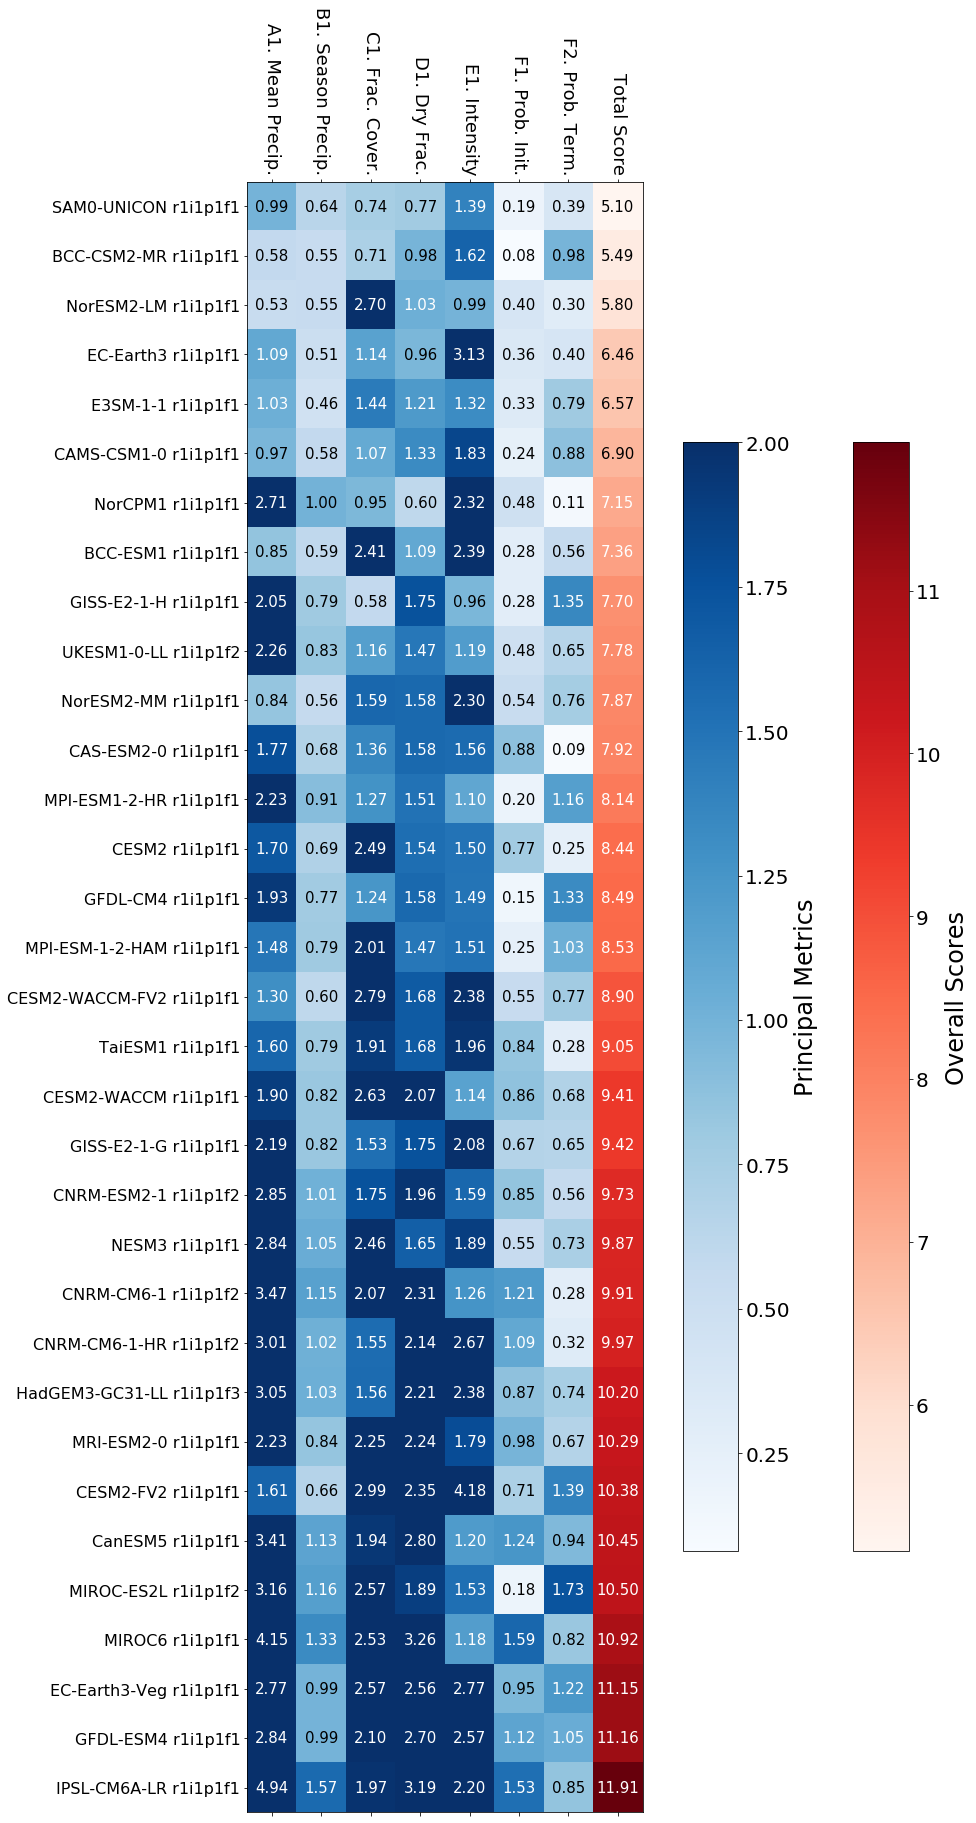

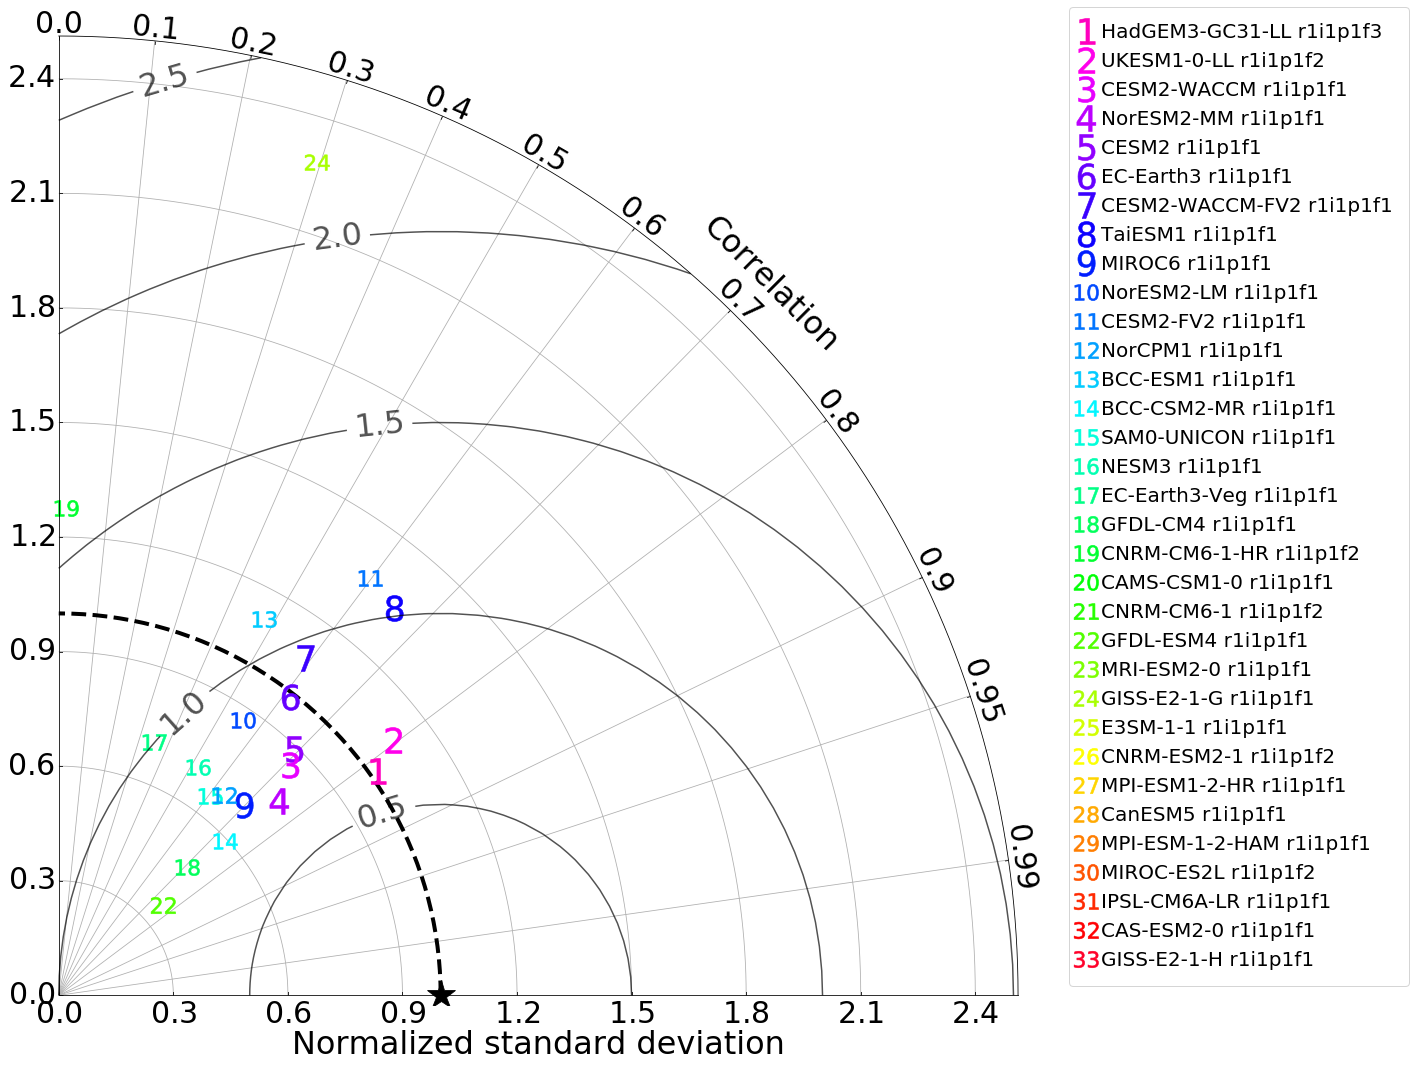

In [7]:
# Conduct the analysis

#the GCMs files' directory
#there are only 3 template files provided. We can use any outputs from CMIP5/6.
test_path = '/data/test/'
#the variable name of precipitation in test data
test_pr_name = 'pr'
# the file of observational data
observe_path = "CPC_monthly_precipitation_to_1_degree.nc"
#the variable name of precipitation in observed data
observe_pr_name = 'precip'
# the path of weightfile used in interpolation, if data are already interpolated, set the interpolation=False in x.evaluate_multi_model()\
# here I use a GCMs file with 1*1 degree resolution
weightfile_path = '/data/weightfile/interpolated_pr_Amon_E3SM-1-1_historical_r1i1p1f1_gr_187001-200912.nc'
#the name of evaluation region in the shapefile
hu_name = 'New England Region'
#the path of shapefile
shp_path = 'HU/WBDHU2.shp'


# Loop over all files under test_path and conduct data analysis
x = evaluation()
x.evaluate_multi_model(test_path,test_pr_name,observe_path,observe_pr_name,weightfile_path,hu_name,shp_path,interpolation=False)


#Conduct the PFA to get Principal Metrics within the region defined. The column names of pricipal metrics are saved at 'output_principal_metrics_column_defined'
# Once we get the name of pricipal metrics defined by PFA. It's no need to run this function again.
#x.PFA()

# Make sure get the name of pricipal metrics defined by PFA firstly. (Here I provide a template named 'output_principal_metrics_column_defined') 
#Select the principal metrics defined at 'output_principal_metrics_column_defined' and make plots 
x.PM_selection()
x.result_analysis(x.principal_metrics)
x.make_taylor_diagram()